<a href="https://colab.research.google.com/github/auroramugnai/arXiv_classification/blob/main/arXiv_classification/category_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Clone the github repository and move to the inner directory.

In [1]:
!git clone https://github.com/auroramugnai/arXiv_classification.git
%cd arXiv_classification/arXiv_classification

Cloning into 'arXiv_classification'...
remote: Enumerating objects: 81, done.
remote: Counting objects: 100% (81/81), done.
remote: Compressing objects: 100% (75/75), done.
remote: Total 81 (delta 40), reused 8 (delta 2), pack-reused 0
Receiving objects: 100% (81/81), 2.98 MiB | 7.83 MiB/s, done.
Resolving deltas: 100% (40/40), done.
/content/arXiv_classification/arXiv_classification


# 1) Build the dataset

In [2]:
import json
import os
import random
import zipfile

import dask.bag as db
import matplotlib.pyplot as plt
import pandas as pd

import utils

In [ ]:
SEED = 42 # fix random seed for reproducibility

## Download the dataset


The following line of code comes from clicking on "Copy API command" in https://www.kaggle.com/datasets/Cornell-University/arxiv.

In [3]:
!kaggle datasets download -d Cornell-University/arxiv

Dataset URL: https://www.kaggle.com/datasets/Cornell-University/arxiv
License(s): CC0-1.0
 99% 1.27G/1.28G [00:16<00:00, 73.5MB/s]
100% 1.28G/1.28G [00:16<00:00, 81.6MB/s]


Unzip the downloaded file.

In [5]:
with zipfile.ZipFile('./arxiv.zip', 'r') as zip_ref:
    zip_ref.extractall()

The unzipping creates an "arxiv-metadata-oai-snapshot.json". We now create a dask bag out of it.

In [6]:
path = "./arxiv-metadata-oai-snapshot.json"
arxiv_data = db.read_text(path).map(json.loads)
arxiv_data.take(1)

({'id': '0704.0001',
  'submitter': 'Pavel Nadolsky',
  'authors': "C. Bal\\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan",
  'title': 'Calculation of prompt diphoton production cross sections at Tevatron and\n  LHC energies',
  'comments': '37 pages, 15 figures; published version',
  'journal-ref': 'Phys.Rev.D76:013009,2007',
  'doi': '10.1103/PhysRevD.76.013009',
  'report-no': 'ANL-HEP-PR-07-12',
  'categories': 'hep-ph',
  'license': None,
  'abstract': '  A fully differential calculation in perturbative quantum chromodynamics is\npresented for the production of massive photon pairs at hadron colliders. All\nnext-to-leading order perturbative contributions from quark-antiquark,\ngluon-(anti)quark, and gluon-gluon subprocesses are included, as well as\nall-orders resummation of initial-state gluon radiation valid at\nnext-to-next-to-leading logarithmic accuracy. The region of phase space is\nspecified in which the calculation is most reliable. Good agreement is\ndemonstrated with d

## Get rid of some unnecessary infomation

In [7]:
# Get the latest version of the articles.
get_latest_version = lambda x: x['versions'][-1]['created']

# Only keep articles published after 2022.
is_after_2022 = lambda x: int(get_latest_version(x).split(' ')[3]) > 2022

# Only keep some information.
cut_info = lambda x: {'id': x['id'],
                      'title': x['title'],
                      'category':x['categories'].split(' '),
                      'abstract':x['abstract'],}

arxiv_data_filtered = (arxiv_data.filter(is_after_2022).map(cut_info).compute())


# Create a pandas dataframe and save it to csv.
df = pd.DataFrame(arxiv_data_filtered)
df.to_csv("./arxiv_data_filtered.csv", index=False)
df.head()

,id,title,category,abstract
0,0705.1329,Third Order Newton's Method for Zernike Polyno...,"[math.NA, cs.NA]",The Zernike radial polynomials are a system ...
1,0706.0190,Quantum Properties and Gravitational Field of ...,[physics.gen-ph],We find that a field with oscillations of ma...
2,0706.0725,Factorization of quadratic polynomials in the ...,"[math.AC, math.GM, math.NT, math.RA]",We establish necessary and sufficient condit...
3,0706.0859,"Profinite complexes of curves, their automorph...","[math.AG, math.NT]","Let ${\cal M}_{g,[n]}$, for $2g-2+n>0$, be t..."
4,0707.0434,Another generalization of Mason's ABC-theorem,[math.NT],We show a generalization of Mason's ABC-theo...


## Balance the dataset

In [20]:
path = "./arxiv_data_filtered.csv"
df = pd.read_csv(path, dtype=str)
df.head()

,id,title,category,abstract
0,0705.1329,Third Order Newton's Method for Zernike Polyno...,"['math.NA', 'cs.NA']",The Zernike radial polynomials are a system ...
1,0706.0190,Quantum Properties and Gravitational Field of ...,['physics.gen-ph'],We find that a field with oscillations of ma...
2,0706.0725,Factorization of quadratic polynomials in the ...,"['math.AC', 'math.GM', 'math.NT', 'math.RA']",We establish necessary and sufficient condit...
3,0706.0859,"Profinite complexes of curves, their automorph...","['math.AG', 'math.NT']","Let ${\cal M}_{g,[n]}$, for $2g-2+n>0$, be t..."
4,0707.0434,Another generalization of Mason's ABC-theorem,['math.NT'],We show a generalization of Mason's ABC-theo...


Set a minimum and maximum threshold for category counts. N.B.: we are referring to category list counts and not single category counts!

In [17]:
num_min = 300
num_max = 400

utils.categories_as_strings(df) # take "category" as a column of strings

# Drop the lists of categories that have less than num_min counts.
cut_num_min = lambda x : len(x) > num_min
df = df.groupby('category').filter(cut_num_min)

# Sample num_max times those categories that have more than num_max counts.
sample_num_max = lambda x: x.sample(min(len(x), num_max))
df = df.groupby('category', as_index = False, group_keys=False)
df = df.apply(sample_num_max).reset_index(drop=True)

print(f"The dataset contains {len(df)} articles.")
df.head()

The dataset contains 63005 articles.


,id,title,category,abstract
0,2310.12759,A case study of early galaxy cluster with the ...,"['astro-ph.CO', 'astro-ph.GA']",Context: Observations of the hot gas in dist...
1,2404.04327,Parameter estimation from Ly$\alpha$ forest in...,"['astro-ph.CO', 'astro-ph.GA']",We aim to present a robust parameter estimat...
2,2309.05647,Forecasting constraints on the high-z IGM ther...,"['astro-ph.CO', 'astro-ph.GA']",The auto-correlation function of the Lyman-$...
3,2209.15038,Exploring the effects of primordial non-Gaussi...,"['astro-ph.CO', 'astro-ph.GA']",While large scale primordial non-Gaussianity...
4,2403.01217,The origin of lopsided satellite galaxy distri...,"['astro-ph.CO', 'astro-ph.GA']",Dwarf satellites in galaxy groups are distri...


Visualize the dataset distribution.

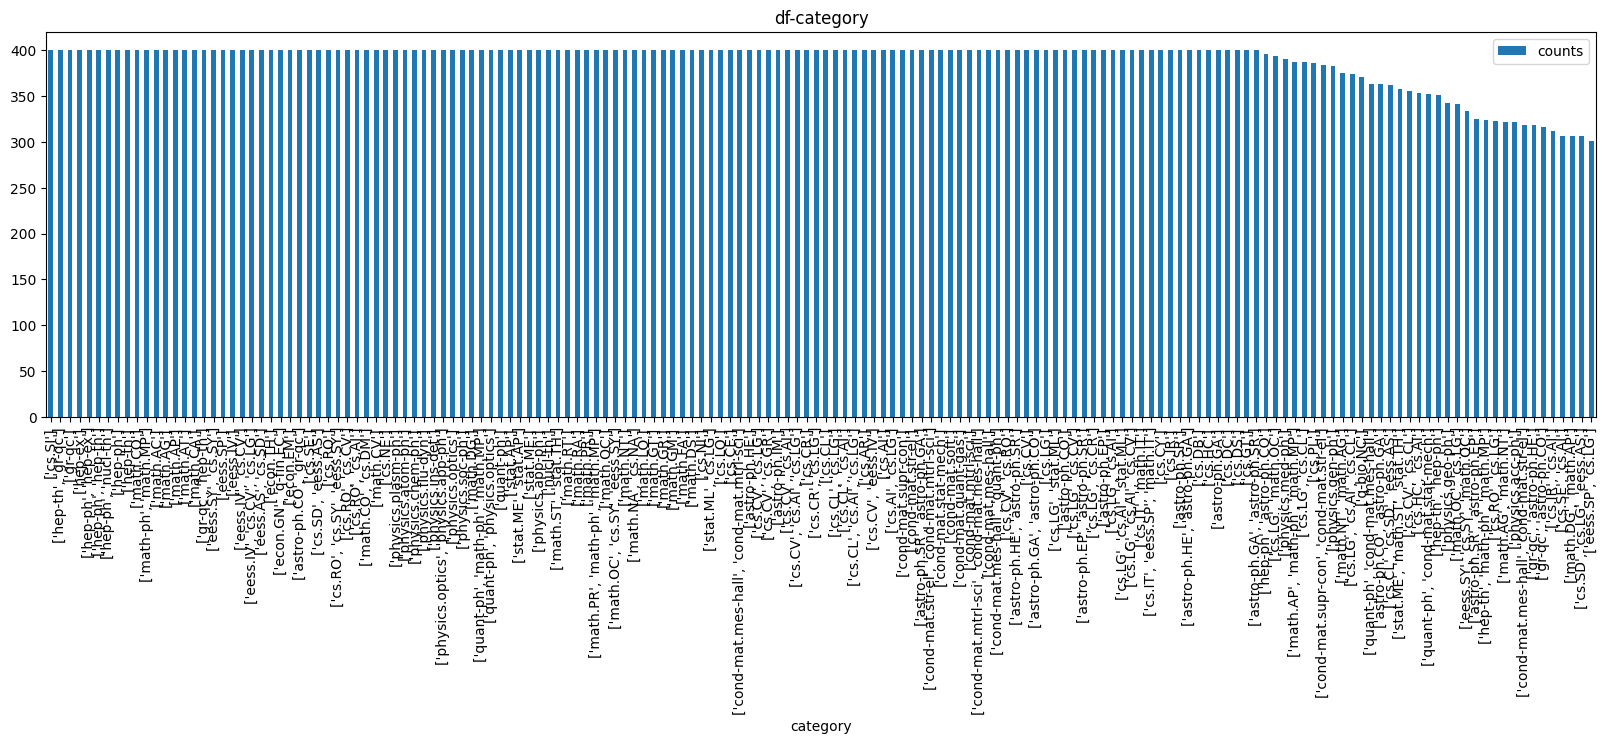

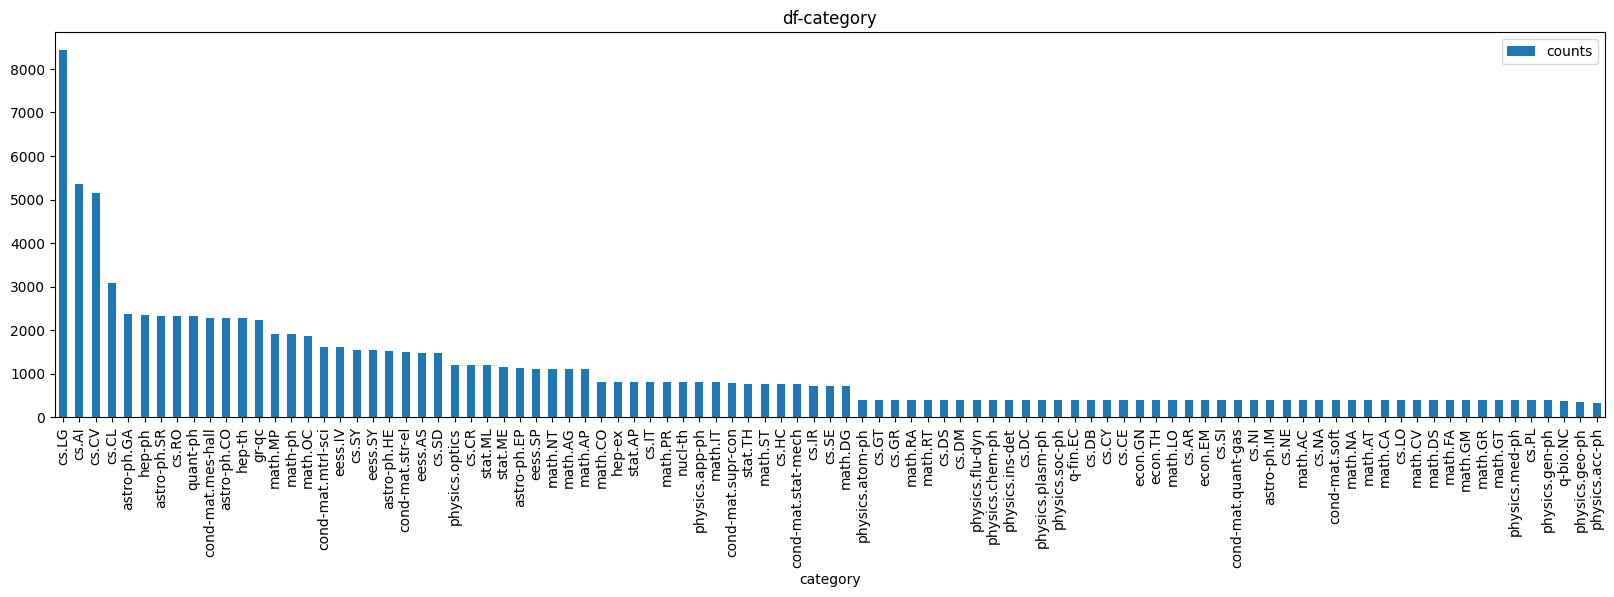

In [18]:
# Get list-of-categories occurrences.
utils.categories_as_strings(df) # take "category" as a column of strings
_ = utils.plot_df_counts(df, col="category")


# Get single-category occurrences.
utils.categories_as_lists(df) # take "category" as a column of lists
df_exp = df.explode("category")
dict_counts_exp = utils.plot_df_counts(df_exp, col="category")

In [19]:
# Get the list of all the single categories.
C  = list(dict_counts_exp.keys())
print(f'Number of categories appearing in the dataset: {len(C)}')

num_to_keep = 20 # keep only a subset of C
sub_C = random.sample(C, num_to_keep)
print(f'Number of categories appearing in the dataset: {len(sub_C)}')

# Take only the articles with a list of categories whose elements are in sub_C.
utils.categories_as_lists(df) # take "category" as a column of lists
df = df.loc[df['category'].explode().isin(sub_C).index]
df.head()

Number of categories appearing in the dataset: 95
Number of categories appearing in the dataset: 20


,id,title,category,abstract
0,2310.12759,A case study of early galaxy cluster with the ...,"[astro-ph.CO, astro-ph.GA]",Context: Observations of the hot gas in dist...
0,2310.12759,A case study of early galaxy cluster with the ...,"[astro-ph.CO, astro-ph.GA]",Context: Observations of the hot gas in dist...
1,2404.04327,Parameter estimation from Ly$\alpha$ forest in...,"[astro-ph.CO, astro-ph.GA]",We aim to present a robust parameter estimat...
1,2404.04327,Parameter estimation from Ly$\alpha$ forest in...,"[astro-ph.CO, astro-ph.GA]",We aim to present a robust parameter estimat...
2,2309.05647,Forecasting constraints on the high-z IGM ther...,"[astro-ph.CO, astro-ph.GA]",The auto-correlation function of the Lyman-$...


## Get a fixed number of articles
To speed up computation and avoid a session crash.

In [ ]:
num_data = 20000 # number of articles that we want to keep
print(f"The dataset contains {len(df)} articles.")

# Sample the dataset only if its length exceeds num_data.
if(len(df) > num_data):
    n_sample = num_data
    random.seed(SEED)
    df = df.sample(n=n_sample, axis=0)

print(f"The dataset contains {len(df)} articles.")

The dataset contains 20576 articles.
The dataset contains 20000 articles.


# 2) Multilabel Classification X=abs+tit y=cat


In [ ]:
!pip install scikit-multilearn
!pip install neattext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.4/89.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 kB 2.5 MB/s eta 0:00:00


In [ ]:
import neattext.functions as nfx
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer,normalize
from sklearn.model_selection import train_test_split

# from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score,classification_report

from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC

In [ ]:
# Preparing X (features)
df["text_to_process"] = df["title"] + df["abstract"]
X = df["text_to_process"].apply(nfx.remove_stopwords)


# Preparing y (labels) as a one-hot encoding.
utils.categories_as_lists(df) # take "category" as a column of lists
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df["category"]) # one-hot encoded
classes = mlb.classes_ # names of the columns of the one-hot-encoding


# Split data into train/test.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=SEED)

In [ ]:
y_df = pd.DataFrame(y, columns=classes)
y_df

,astro-ph.EP,astro-ph.GA,astro-ph.HE,astro-ph.SR,cond-mat.mes-hall,cond-mat.mtrl-sci,cond-mat.str-el,cs.AI,cs.CE,cs.CL,...,math.OC,math.RA,math.RT,physics.acc-ph,physics.chem-ph,q-bio.NC,q-fin.EC,quant-ph,stat.AP,stat.ME
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19996,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19997,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
19998,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Perform classification

In [ ]:
from utils_classification import *

In [ ]:
SVM_pipeline = Pipeline([('tfidf', TfidfVectorizer(stop_words='english')),
                         ('svm_model', OneVsRestClassifier(LinearSVC(), n_jobs=-1))])

y_pred, mat = run_SVM_pipeline_multi(SVM_pipeline, X_train, X_test, y_train, y_test)
print('accuracy: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=classes))

accuracy:  0.5648333333333333
                   precision    recall  f1-score   support

      astro-ph.EP       0.97      0.83      0.89       205
      astro-ph.GA       0.87      0.79      0.83       354
      astro-ph.HE       0.96      0.95      0.96       565
      astro-ph.SR       0.95      0.95      0.95       798
cond-mat.mes-hall       0.98      0.97      0.98       630
cond-mat.mtrl-sci       0.76      0.64      0.69       232
  cond-mat.str-el       0.70      0.36      0.48        83
            cs.AI       0.44      0.20      0.27       358
            cs.CE       0.91      0.38      0.53       138
            cs.CL       0.69      0.58      0.63       187
            cs.CV       0.97      0.97      0.97      1526
            cs.CY       0.79      0.42      0.55       127
            cs.DS       0.92      0.68      0.78       124
            cs.GR       0.81      0.49      0.61       110
            cs.GT       0.90      0.71      0.79       116
            cs.IT       0

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Print confusion matrices

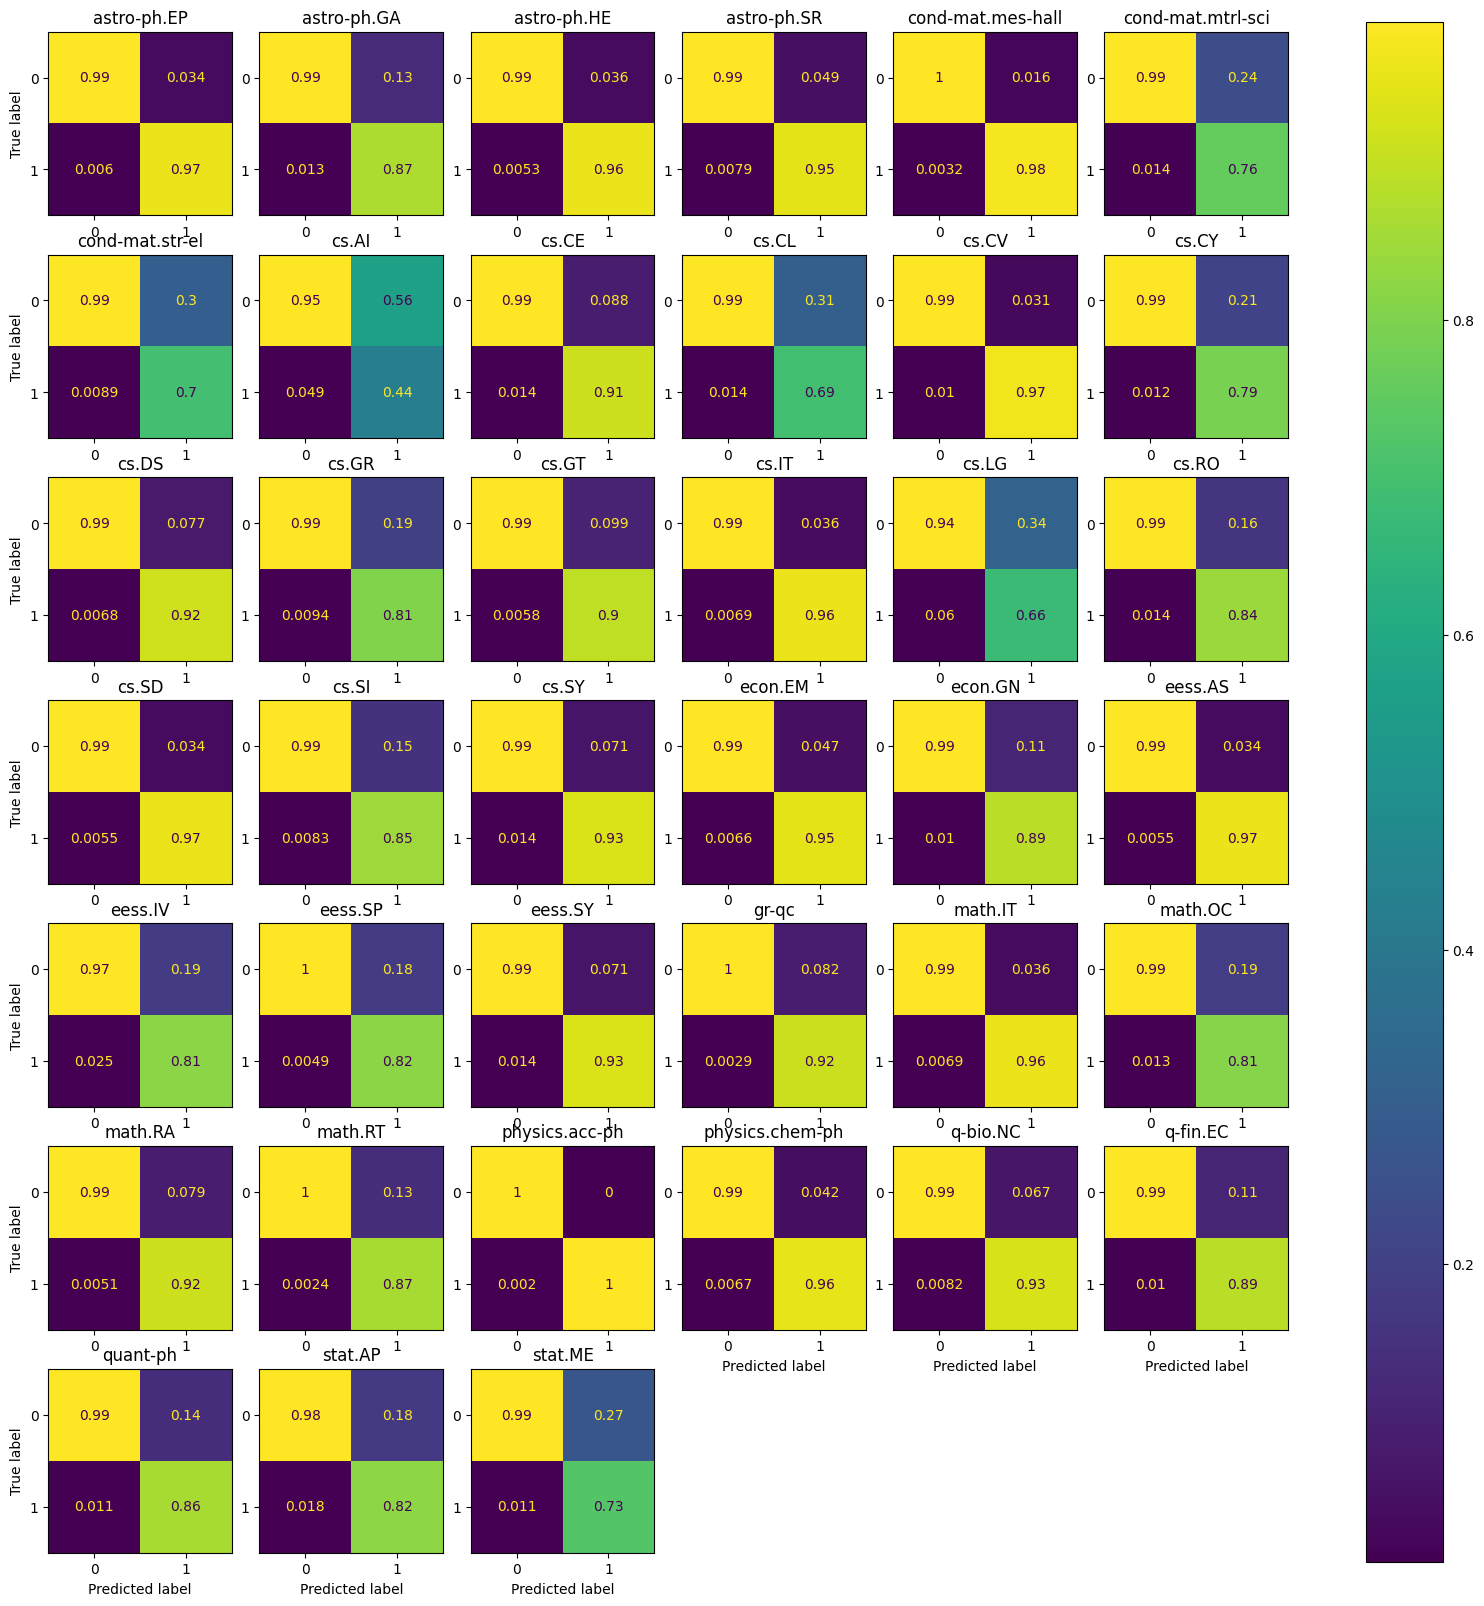

In [ ]:
print_confusion_matrices(mat, classes)

In [ ]:
# # Show some predictions
# yy_test = mlb.inverse_transform(y_test)
# yy_pred = mlb.inverse_transform(y_pred)

# for i,(yt, yp) in enumerate(zip(yy_test, yy_pred)):
#   if i==5: continue
#   print("-"*20)
#   print(f"  true   : {yt}")
#   print(f"predicted: {yp}")

## ROC curve

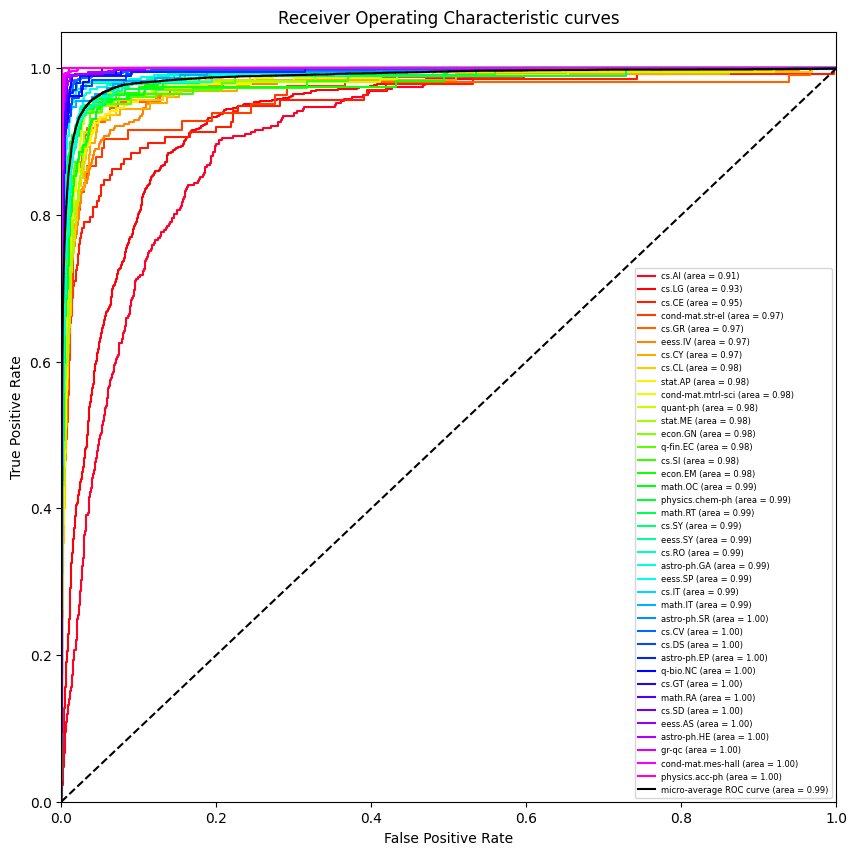

In [ ]:
y_score = SVM_pipeline.fit(X_train, y_train).decision_function(X_test)
ROC(classes, y_test, y_score)

# 3) Keywords extraction

In [ ]:
!pip install keyphrase-vectorizers -q
!pip install sematch -q
!pip install nltk -q
!pip install KeyBERT -q
!pip install -U spacy -q # spacy package to preprocess the abstract text
!python -m spacy download en_core_web_sm -q
!pip install neattext -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.8/197.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.3/240.3 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.5/363.5 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.8/772.8 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.3/236.3 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.0/314.0 kB 25.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 28.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 531.9/531.9 kB 29.

In [ ]:
import neattext.functions as nfx
from sklearn.feature_extraction.text import TfidfVectorizer
from keybert import KeyBERT
from keyphrase_vectorizers import KeyphraseCountVectorizer
import spacy
import string
import en_core_web_sm
# from functools import reduce
from tqdm import tqdm

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [ ]:
from utils_keywords import *

## Texts processing

In [ ]:
# Remove stop words and apply the remove function
nlp = spacy.load("en_core_web_sm")
tqdm.pandas()
rem_abs = lambda x: remove(text=x["abstract"], nlp=nlp)
df['abstract'] = df['abstract'].progress_apply(nfx.remove_stopwords)
df["abstract_processed"] = df.progress_apply(rem_abs, axis=1)
rem_tit = lambda x: remove(text=x["title"], nlp=nlp)
df["title"] = df['title'].progress_apply(nfx.remove_stopwords)
df["title_processed"] = df.progress_apply(rem_tit, axis=1)
df.tail()

100%|██████████| 20000/20000 [03:25<00:00, 97.43it/s] 


,id,title,category,abstract,text_to_process,abstract_processed,title_processed
16790,2311.04634,VET: Visual Error Tomography Point Cloud Compl...,"[cs.CV, cs.GR]","years, deep neural networks opened doors big a...",VET: Visual Error Tomography for Point Cloud C...,year deep neural network open door big advance...,vet visual error tomography point cloud comple...
5375,2301.03932,Discovery dusty sub-solar mass young stellar o...,"[astro-ph.SR, astro-ph.GA]","JWST observations NGC 346, star-forming region...",Discovery of dusty sub-solar mass young stella...,jwst observation ngc star form region metal po...,discovery dusty sub solar mass young stellar o...
50772,2211.14010,Circuit Analysis Monotone+Skew Splitting,"[math.OC, cs.SY, eess.SY]",shown behavior $m$-port circuit maximal monoto...,Circuit Analysis using Monotone+Skew Splitting...,show behavior circuit maximal monotone element...,circuit analysis splitting
59199,2403.12099,Left-handedness zero-absorption windows tuned ...,"[quant-ph, cond-mat.mes-hall]",Left-handedness zero-absorption windows achiev...,Left-handedness with three zero-absorption win...,left handedness zero absorption window achieve...,left handedness zero absorption window tune in...
3897,2401.00977,X-ray plasma flow turbulence colliding winds W...,"[astro-ph.HE, astro-ph.SR]",analyse $\textit{XMM-Newton}$ RGS spectra Wolf...,X-ray plasma flow and turbulence in the collid...,analyse rgs spectra wolf rayet wr archetype lo...,x ray plasma flow turbulence collide wind


In [ ]:
# Add a space to separate title and abstract
df["title_processed"] = df["title_processed"].astype(str) + " "
df["TEXT"] = df["title_processed"] + df["abstract_processed"]

# Save to csv
df.to_csv(f"./processed_dataframe.csv", index=False)
df.head()

,id,title,category,abstract,text_to_process,abstract_processed,title_processed,TEXT
53850,2305.06775,Large-Aperture High-Field NB3SN Magnets 2nd EI...,[physics.acc-ph],"design concept Electron Ion Collider (EIC), co...",Large-Aperture High-Field NB3SN Magnets for th...,design concept electron ion collider eic const...,large aperture high field magnets eic interact...,large aperture high field magnets eic interact...
3723,2211.05789,Inferring Type II-P Supernova Progenitor Masse...,"[astro-ph.HE, astro-ph.SR]",Connecting observations core-collapse supernov...,Inferring Type II-P Supernova Progenitor Masse...,connect observation core collapse supernova ex...,infer type ii p supernova progenitor masses pl...,infer type ii p supernova progenitor masses pl...
23303,2309.14054,Adapt Unlearn: Exploiting Parameter Space Sema...,"[cs.LG, cs.AI, cs.CV]",increased attention regulating outputs deep ge...,Adapt then Unlearn: Exploiting Parameter Space...,increase attention regulate output deep genera...,adapt unlearn exploit parameter space semantic...,adapt unlearn exploit parameter space semantic...
36734,2305.18214,Electromagnetic field charge asymptotically ap...,"[gr-qc, astro-ph.HE]",consider test charged particle falling Schwarz...,Electromagnetic field of a charge asymptotical...,consider test charge particle fall schwarzschi...,electromagnetic field charge asymptotically ap...,electromagnetic field charge asymptotically ap...
7723,2302.10529,Combined electronic excitation knock-on damage...,"[cond-mat.mtrl-sci, cond-mat.mes-hall]",Electron irradiation-induced damage limiting f...,Combined electronic excitation and knock-on da...,electron irradiation induce damage limit facto...,combined electronic excitation knock on damage...,combined electronic excitation knock on damage...


## Extract the keywords

In [ ]:
kw_model = KeyBERT('all-mpnet-base-v2')

# Apply keyword extraction to the data.
tqdm.pandas()
df2 = df.copy(deep=False)
extraction = lambda x: extract_kws(TEXT=x["TEXT"], kw_model=kw_model, seed=x["title_processed"].split(" "))
df2["keywords"] = df2.progress_apply(extraction, axis=1)
df2.head()

  2%|▏         | 434/20000 [17:52<13:07:53,  2.42s/it]

In [ ]:
df2.to_csv(f"./keywords.csv", index=False) # Save to csv

# 4) Classification X=kws, y=cat


In [ ]:
df = df2.copy(deep=False)
df.head()

In [ ]:
df = pd.read_csv("./keywords.csv", dtype=str)
print(f"The dataset contains {len(df)} articles.")

# Preparing X (features)
X = df["keywords"]


df["category"] =  df["category"].map(eval)
mlb = MultiLabelBinarizer()
y = mlb.fit_transform(df["category"])
classes = mlb.classes_ # names of the columns of the one-hot-encoding

#Split data into train/test.
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3, random_state=SEED)

In [ ]:
y_df = pd.DataFrame(y, columns=classes)
y_df

In [ ]:
y_pred, mat = run_SVM_pipeline_multi(SVM_pipeline, X_train, X_test, y_train, y_test)
print('accuracy: ', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=classes))

Print the confusion matrices

In [ ]:
print_confusion_matrices(mat, classes)

In [ ]:
# # Show some predictions
# yy_test = mlb.inverse_transform(y_test)
# yy_pred = mlb.inverse_transform(y_pred)

# for i, (yt, yp) in enumerate(zip(yy_test, yy_pred)):
#   print("-"*20)
#   print(f"  true   : {yt}")
#   print(f"predicted: {yp}")
#   if(i == 10): continue

## ROC curve

In [ ]:
y_score = SVM_pipeline.fit(X_train, y_train).decision_function(X_test)
ROC(classes, y_test, y_score)